# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import struct
import time
from decimal import Decimal

# Get weight values

In [2]:
total_num_of_weight = 401
def get_weights_arr():
    weights_arr = []
    w_val = Decimal('-2.0')
    step = Decimal('0.01')
    for i in range (total_num_of_weight):
        weights_arr.append(float(w_val))
        w_val += step
    return weights_arr

weights_arr = get_weights_arr()
#the weight value to be recovered
true_weight = 1.43

# Function Definitions

In [3]:
def float_to_binary_str(f):
    # Pack the float into 4 bytes (32-bit) using IEEE 754 standard
    [packed] = struct.unpack('!I', struct.pack('!f', f))
    # Convert the packed number to a binary string
    return f"{packed:032b}"

In [4]:
def HW_float32(f):
    # Get the binary representation of the 32-bit float
    binary_str = float_to_binary_str(f)
    # Count and return the number of '1' bits
    return binary_str.count('1')

In [5]:
#get one part of the binary representation
def getbyte(f,byte_position):
    if byte_position == 0:#sign bit
        inbinary = float_to_binary_str(f)[0]
    elif byte_position == 4:#last 7 bits
        inbinary = float_to_binary_str(f)[25:32]
    else:
        inbinary = float_to_binary_str(f)[(byte_position-1)*8+1:byte_position*8+1]
    
    return int(inbinary,2)

#### The values to be recovered

In [6]:
#true values of different parts of the weight
true_sign_bit = getbyte(true_weight,0)
true_exponent_bits = getbyte(true_weight,1)
true_byte_two = getbyte(true_weight,2)
true_byte_three = getbyte(true_weight,3)
true_byte_four = getbyte(true_weight,4)
true_value_index = weights_arr.index(true_weight)

In [7]:
print("sign bit = " + str(true_sign_bit) + ", exponent = " + str(true_exponent_bits) + ", first mantissa byte = " + str(true_byte_two) + ", second mantissa byte = " + str(true_byte_three) + ", last 7 bits = " + str(true_byte_four))

sign bit = 0, exponent = 127, first mantissa byte = 110, second mantissa byte = 20, last 7 bits = 61


In [8]:
def get_hypothetical_leakages(num_of_traces, inputs_arr):
    hypothetical_leakages = [[] for i in range(total_num_of_weight)]
    for weight_index in range(total_num_of_weight):
        for j in range(num_of_traces):
            #compute the hypothetical product values for each hypothetical value of weight and each random input
            hypothetical_product = weights_arr[weight_index] * inputs_arr[j]
            #compute hypothetical leakages
            hypothetical_leakages[weight_index].append(HW_float32(hypothetical_product))
    return np.array(hypothetical_leakages)

In [9]:
def CPA_attack(num_of_traces, inputs_arr, total_time_sample, start_time_sample, trace_arr):
    r_abs = [[] for i in range(total_num_of_weight)]
    #get hypothetical leakages
    hypothetical_leakages = get_hypothetical_leakages(num_of_traces, inputs_arr)
    for t in range(total_time_sample):
        time_sample_index = t + start_time_sample
        if t%100 == 0:
            print("calculating for time sample " + str(time_sample_index))
        for weight_index in range(total_num_of_weight):
            corr_coef = np.corrcoef(hypothetical_leakages[weight_index],trace_arr[:,time_sample_index])[0][1]
            r_abs[weight_index].append(abs(corr_coef))
    return r_abs  

In [10]:
def recover_byte(correlation_arr, byte_position, total_time_sample):
    num_of_different_values = 256 #for byte two and three and exponent bits, we have 256 different values
    if byte_position == 0:#for sign bit, there are just 2 different values
        num_of_different_values = 2
    if byte_position == 4:#for last 7 bits, there are 2^7 different values
        num_of_different_values = 128
    correlations = [[0 for t in range(total_time_sample)] for i in range(num_of_different_values)]
    for weight_index in range(total_num_of_weight):#for each weight
        byte_value = getbyte(weights_arr[weight_index],byte_position)#for the chosen byte of this weight value
        for t in range(total_time_sample):#take the correlations for this weight value, for each time sample, update the correlations
            if correlation_arr[weight_index][t] > correlations[byte_value][t]:
                correlations[byte_value][t] = correlation_arr[weight_index][t]
        
    return correlations

In [11]:
def plot_correlations(correlation, value_index, total_time_sample, start_time_sample):
    x = []
    total_plots = len(correlation)
    
    for t in range(total_time_sample):
        x.append(t+start_time_sample)
    
    plt.plot(x,correlation[value_index], color="r")
    
    for i in range(total_plots):
        if i == value_index:
            continue
        else: 
            plt.plot(x,correlation[i], color="#808080")
    return

In [12]:
def savefile(foldername, filename, arr, total_time_sample, start_time_sample):
    f = open(foldername + "//" + filename + ".txt", "w")
    length = len(arr)#number of columns
    
    
    #first line
    f.write("x ")
    for i in range(length):
        f.write("y"+str(i)+" ")
    f.write("\n")
    
    for t in range(total_time_sample):#for each line
        f.write(str(t+start_time_sample)+" ")#first write down the time sample
        for j in range(length):
            f.write(str(arr[j][t])+" ")
        f.write("\n")
    f.close()
    return

In [13]:
def load_traces(num_of_traces, folder_name):
    trace_waves_arr = []
    inputs_arr = []

    for i in range(num_of_traces):
        with open(folder_name + '/trace_'+str(i)+'.txt') as f:
            lines = f.read().splitlines()
            trace_waves_arr.append(lines)

    with open(folder_name + '/inputs.txt') as f:
        inputs_arr = f.read().splitlines()
    trace_waves_arr = np.array(trace_waves_arr)
    trace_waves_arr = trace_waves_arr.astype(float)

    inputs_arr = np.array(inputs_arr)
    inputs_arr = inputs_arr.astype(float)
    return trace_waves_arr, inputs_arr

In [14]:
#### Find the maximum values for correlations for first byte of mantissa
def find_max_first_byte(total_time_sample, start_time_sample, foldername, filename, cor):
    max_values = [0 for t in range(total_time_sample)]
    for t in range(total_time_sample):
        for ex in range(256):
            if ex == true_byte_two:
                continue
            else:
                if(cor[ex][t] > max_values[t]):
                    max_values[t]= cor[ex][t]
                
    #save the file
    f = open(foldername + "//" + filename + ".txt", "w")    
    
    #first line---
    f.write("x y\n")
    #other lines
    for t in range(total_time_sample):#for each line
        f.write(str(t+start_time_sample)+" " + str(max_values[t])+"\n")#first write down the time sample, then the correlation value
    f.close()
    return

# Attack on unprotected traces

In [15]:
traces, inputs = load_traces(num_of_traces=2000, folder_name="unprotected")

In [16]:
start = 490
end = 1011
total = end - start

In [17]:
r = CPA_attack(num_of_traces=2000, inputs_arr=inputs, total_time_sample=total, start_time_sample=start, trace_arr=traces)

calculating for time sample 490
calculating for time sample 590
calculating for time sample 690
calculating for time sample 790
calculating for time sample 890
calculating for time sample 990


#### Correlations for each weight value

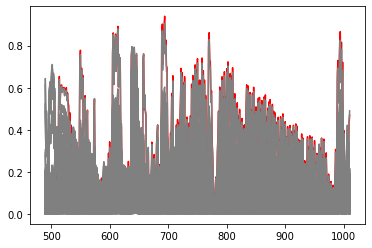

In [18]:
plot_correlations(r,true_value_index, total, start)

#### Sign bit recovery

In [19]:
correlations_sign_bit = recover_byte(r, 0, total)

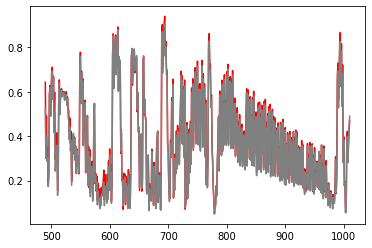

In [20]:
plot_correlations(correlations_sign_bit, true_sign_bit, total, start)

#### Exponent bits ecovery

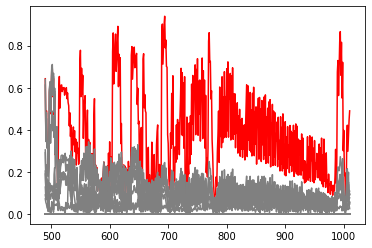

In [21]:
correlations_exponent_bits = recover_byte(r,1, total)
plot_correlations(correlations_exponent_bits, true_exponent_bits, total, start)

#### First byte of mantissa

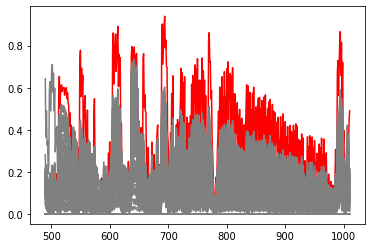

In [22]:
correlations_byte_two = recover_byte(r, 2, total)
plot_correlations(correlations_byte_two, true_byte_two, total, start)

#### Second byte of mantissa

In [23]:
correlations_byte_three = recover_byte(r, 3, total)

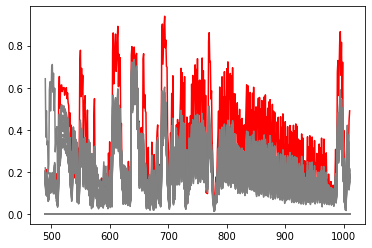

In [24]:
plot_correlations(correlations_byte_three, true_byte_three, total, start)

#### Last 7 bits recovery

In [25]:
correlations_byte_four = recover_byte(r, 4, total)

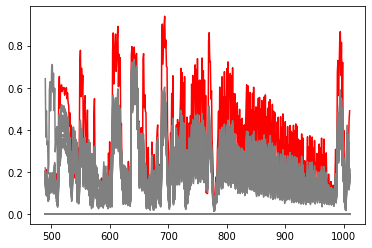

In [26]:
plot_correlations(correlations_byte_four, true_byte_four, total, start)

In [27]:
savefile("correlations", "signbit", correlations_sign_bit, total, start)
savefile("correlations", "exponentbits", correlations_exponent_bits, total, start)
savefile("correlations", "firstbyte", correlations_byte_two, total, start)
savefile("correlations", "secondbyte", correlations_byte_three, total, start)
savefile("correlations", "lastbits", correlations_byte_four, total, start)

In [28]:
find_max_first_byte(total, start, "correlations", "firstbyte_max", correlations_byte_two)

# Attack on protected traces

In [30]:
traces_pro, inputs_pro = load_traces(num_of_traces=10000, folder_name="protected")

In [43]:
start = 490
end_pro = 4301
total_pro = end_pro - start

In [44]:
r_pro = CPA_attack(num_of_traces=10000, inputs_arr=inputs_pro, total_time_sample=total_pro, start_time_sample=start, trace_arr=traces_pro)

calculating for time sample 490
calculating for time sample 590
calculating for time sample 690
calculating for time sample 790
calculating for time sample 890
calculating for time sample 990
calculating for time sample 1090
calculating for time sample 1190
calculating for time sample 1290
calculating for time sample 1390
calculating for time sample 1490
calculating for time sample 1590
calculating for time sample 1690
calculating for time sample 1790
calculating for time sample 1890
calculating for time sample 1990
calculating for time sample 2090
calculating for time sample 2190
calculating for time sample 2290
calculating for time sample 2390
calculating for time sample 2490
calculating for time sample 2590
calculating for time sample 2690
calculating for time sample 2790
calculating for time sample 2890
calculating for time sample 2990
calculating for time sample 3090
calculating for time sample 3190
calculating for time sample 3290
calculating for time sample 3390
calculating for 

#### Correlations for each weight value

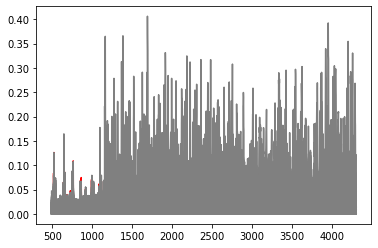

In [45]:
plot_correlations(r_pro,true_value_index, total_pro, start)

#### Sign bit recovery

In [46]:
correlations_sign_bit_pro = recover_byte(r_pro, 0, total_pro)

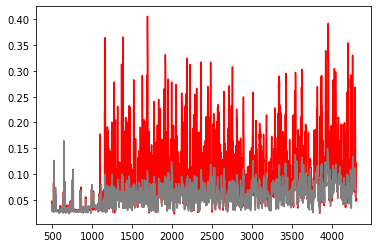

In [47]:
plot_correlations(correlations_sign_bit_pro, true_sign_bit, total_pro, start)

#### Exponent bits ecovery

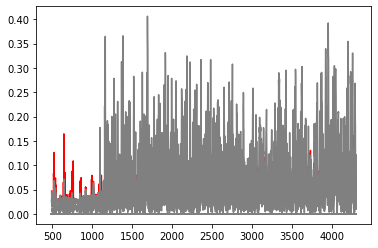

In [48]:
correlations_exponent_bits_pro = recover_byte(r_pro, 1, total_pro)
plot_correlations(correlations_exponent_bits_pro, true_exponent_bits, total_pro, start)

#### First byte of mantissa

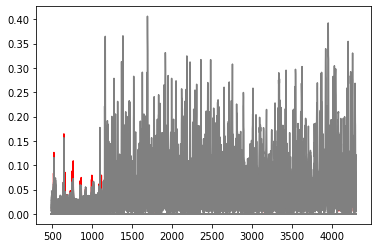

In [49]:
correlations_byte_two_pro = recover_byte(r_pro, 2, total_pro)
plot_correlations(correlations_byte_two_pro, true_byte_two, total_pro, start)

#### Second byte of mantissa

In [50]:
correlations_byte_three_pro = recover_byte(r_pro, 3, total_pro)

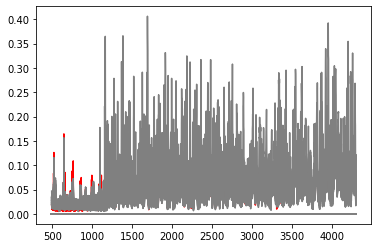

In [51]:
plot_correlations(correlations_byte_three_pro, true_byte_three, total_pro, start)

#### Last 7 bits recovery

In [52]:
correlations_byte_four_pro = recover_byte(r_pro, 4, total_pro)

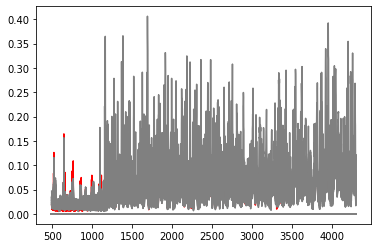

In [53]:
plot_correlations(correlations_byte_four_pro, true_byte_four, total_pro, start)

In [54]:
savefile("correlations-protected", "shuffled_signbit", correlations_sign_bit_pro, total_pro, start)
savefile("correlations-protected", "shuffled_exponentbits", correlations_exponent_bits_pro, total_pro, start)
savefile("correlations-protected", "shuffled_firstbyte", correlations_byte_two_pro, total_pro, start)
savefile("correlations-protected", "shuffled_secondbyte", correlations_byte_three_pro, total_pro, start)
savefile("correlations-protected", "shuffled_lastbits", correlations_byte_four_pro, total_pro, start)

In [55]:
find_max_first_byte(total_pro, start, "correlations-protected", "shuffled_firstbyte_max", correlations_byte_two_pro)

# Find all the possible values for each part of the binary representation

In [29]:
def print_bytes_for_all():
    all_bytes_values = [[] for i in range(4)]
    
    for i in range(4):
        for weight_value in weights_arr:
            all_bytes_values[0].append(getbyte(weight_value,1))#exponent bytes
            all_bytes_values[1].append(getbyte(weight_value,2))#first byte of mantissa
            all_bytes_values[2].append(getbyte(weight_value,3))#second byte of mantissa
            all_bytes_values[3].append(getbyte(weight_value,4))#last 7 bits
    
    distinct_values = [[] for i in range(4)]
    value_frequency = [[] for i in range(4)]
    num_of_distinct_values = [0 for i in range(4)]
    for i in range(4):
        values, counts = np.unique(all_bytes_values[i], return_counts=True)
        distinct_values[i] = values
        value_frequency[i] = counts
        num_of_distinct_values[i] = len(distinct_values[i])
    
    bytename = ["exponent bits", "first byte of mantissa", "second byte of mantissa", "last 7 bits"]
    for i in range(4):
        print("\nThere are " + str(num_of_distinct_values[i]) + " distinct " + bytename[i])
        for j in range(num_of_distinct_values[i]):
            print(str(distinct_values[i][j]) + ", ", end="")
        print("\nwith frequencies:")
        print(value_frequency[i])
    return

print_bytes_for_all()


There are 10 distinct exponent bits
0, 120, 121, 122, 123, 124, 125, 126, 127, 128, 
with frequencies:
[  4   8  16  24  48  96 200 400 800   8]

There are 100 distinct first byte of mantissa
0, 2, 5, 7, 10, 12, 15, 17, 20, 23, 25, 28, 30, 33, 35, 38, 40, 43, 46, 48, 51, 53, 56, 58, 61, 64, 66, 69, 71, 74, 76, 79, 81, 84, 87, 89, 92, 94, 97, 99, 102, 104, 107, 110, 112, 115, 117, 120, 122, 125, 128, 130, 133, 135, 138, 140, 143, 145, 148, 151, 153, 156, 158, 161, 163, 166, 168, 171, 174, 176, 179, 181, 184, 186, 189, 192, 194, 197, 199, 202, 204, 207, 209, 212, 215, 217, 220, 222, 225, 227, 230, 232, 235, 238, 240, 243, 245, 248, 250, 253, 
with frequencies:
[36  8 16  8 32  8 16  8 24  8 16  8 40  8 16  8 24  8 16  8 32  8 16  8
 24  8 16  8 64  8 16  8 24  8 16  8 32  8 16  8 24  8 16  8 40  8 16  8
 24  8 16  8 32  8 16  8 24  8 16  8 48  8 16  8 24  8 16  8 32  8 16  8
 24  8 16  8 40  8 16  8 24  8 16  8 32  8 16  8 24  8 16  8 56  8 16  8
 24  8 16  8]

There are 25 distinct sec